# Simulation Class: Tutorial 6

This notebook will demonstrate how to use the `Simulation` class of the pulsar signal simulator for more automated simulation of data. The `Simulation` class is designed as a convenience class within the `PsrSigSim`. Instead of instantiating each step of the simulation, the `Simulation` class allows the input of all desired variables for the simulation at once, and then will run all parts of the simulation. The `Simulation` class also allows for individual running of each step (e.g. `Signal`, `Pulsar`, etc.) if desired. Not all options available within the `Simulation` will be demonstrated in this notebook. 

In [1]:
# import some useful packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# import the pulsar signal simulator
import psrsigsim as pss

Instead of defining each variable individually, the simulation class gets instantiated all at once. This can be done either by defining each variable individually, or by passing a dictionary with all parameters defined to the simulator. The dictionary keys should be the same as the input flags for the `Simulation` class.

In [2]:
sim = pss.simulate.Simulation(
                 fcent = 430, # center frequency of observation, MHz
                 bandwidth = 100, # Bandwidth of observation, MHz
                 sample_rate = 1.0*2048*10**-6, # Sampling rate of the data, MHz
                 dtype = np.float32, # data type to write out the signal in
                 Npols = 1, # number of polarizations to simulate, only one available
                 Nchan = 64, # number of subbands for the observation
                 sublen = 2.0, # length of subintegration of signal
                 fold = True, # flag to produce fold-mode, subintegrated data
                 period = 1.0, # pulsar period in seconds
                 Smean = 1.0, # mean flux of the pulsar in Jy
                 profiles = [0.5, 0.05, 1.0], # Profile - may be a data array, list of Gaussian components, or profile class object
                 tobs = 4.0, # length of observation in seconds
                 name = 'J0000+0000', # name of the simulated pulsar
                 dm = 10.0, # dispersion measure in pc cm^-3
                 tau_d = None, # scattering timescale in seconds
                 tau_d_ref_f = None, # reference frequency of scattering timescale in seconds
                 aperture = 100.0, # telescope aperture in meters
                 area = 5500.0, # telescope area in meters square
                 Tsys = 35.0, # telescope system temperature
                 tscope_name = "TestScope", # telescope name (default GBT and Arecibo available)
                 system_name = "TestSys", # observing system name
                 rcvr_fcent = 430, # center frequency of the receiver in MHz
                 rcvr_bw = 100, # receiver bandwidth in MHz
                 rcvr_name ="TestRCVR", # name of receiver
                 backend_samprate = 1.5625, # bandend maximum sampling rate in MHz
                 backend_name = "TestBack", # bandend name
                 tempfile = None, # optional name of template fits file to simulate
                 psrdict = None, # optional dictionary to give for input parameters
                 )

To give the `Simulation` class a dictionary of these parameters, the input may look something like below (Note - all parameters have the same units and names as above). 

In [3]:
pdict = {'fcent' : 430,
         'bandwidth' : 100,
         'sample_rate' : 1.0*2048*10**-6,
         'dtype' : np.float32,
         'Npols' : 1,
         'Nchan' : 64,
         'sublen' : 2.0,
         'fold' : True,
         'period' : 1.0,
         'Smean' : 1.0,
         'profiles' : [0.5, 0.05, 1.0],
         'tobs' : 4.0,
         'name' : 'J0000+0000',
         'dm' : 10.0,
         'tau_d' : None,
         'tau_d_ref_f' : None,
         'aperture' : 100.0,
         'area' : 5500.0,
         'Tsys' : 35.0,
         'tscope_name' : "TestScope",
         'system_name' : "TestSys",
         'rcvr_fcent' : 430,
         'rcvr_bw' : 100,
         'rcvr_name' : "TestRCVR",
         'backend_samprate' : 1.5625,
         'backend_name' : "TestBack",
         'tempfile' : None,
        }

sim = pss.simulate.Simulation(psrdict = pdict)

## Simulating the Data

Once the `Simulation` class is initialized with all of the necessary parameters, there are two ways to run the simulation. The first is simply by running the `simulate()` function, which will fully simulate the the data from start to finish.

In [4]:
sim.simulate()

98% dispersed in 0.050 seconds.

If we want to look at the data that has been simulated, it can be accessed via `sim.signal.data`. The simulate class has attributes for each of the objects simulated (e.g. `signal`, `pulsar`, etc.) if the user would like to access those parameters. We will look at the simulated data and plot it below.

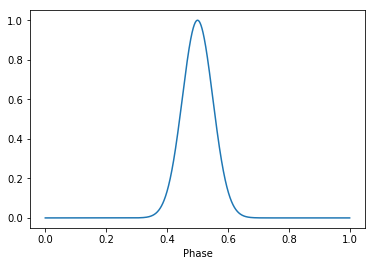

In [5]:
# We can look at the simulated profiles
plt.plot(np.linspace(0,1,2048), sim.profiles.profiles[0])
plt.xlabel("Phase")
plt.show()
plt.close()

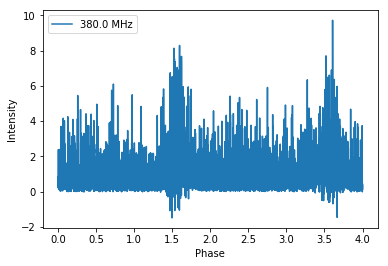

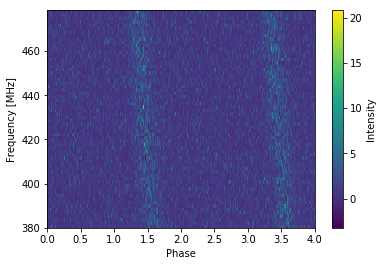

In [6]:
# Get the simulated data
sim_data = sim.signal.data

# Get the phases of the pulse
phases = np.linspace(0, sim.tobs/sim.period, len(sim_data[0,:]))
# Plot just the pulses in the first frequency channels
plt.plot(phases, sim_data[0,:], label = sim.signal.dat_freq[0])
plt.ylabel("Intensity")
plt.xlabel("Phase")
plt.legend(loc = 'best')
plt.show()
plt.close()

# Make the 2-D plot of intensity v. frequency and pulse phase. You can see the slight dispersive sweep here.
plt.imshow(sim_data, aspect = 'auto', interpolation='nearest', origin = 'lower', \
           extent = [min(phases), max(phases), sim.signal.dat_freq[0].value, sim.signal.dat_freq[-1].value])
plt.ylabel("Frequency [MHz]")
plt.xlabel("Phase")
plt.colorbar(label = "Intensity")
plt.show()
plt.close()

### A second way to simulate

The second way to run these simulations is by initializing all of the different objects separately, instead of through the simulation class. This allows slightly more freedom, as well as modifications to the initially input simulated parameters.

In [7]:
# We start by initializing the signal
sim.init_signal()
# Initialize the profile
sim.init_profile()
# Now the pulsar
sim.init_pulsar()
# Now the ISM
sim.init_ism()
# Now make the pulses
sim.pulsar.make_pulses(sim.signal, tobs = sim.tobs)
# disperse the simulated pulses
sim.ism.disperse(sim.signal, sim.dm)
# Now add the telescope and radiometer noise
sim.init_telescope()
# add radiometer noise
out_array = sim.tscope.observe(sim.signal, sim.pulsar, system=sim.system_name, noise=True)

98% dispersed in 0.055 seconds.

If we plot the results here we find that they are identical within the error of the simulated noise to what we have above.

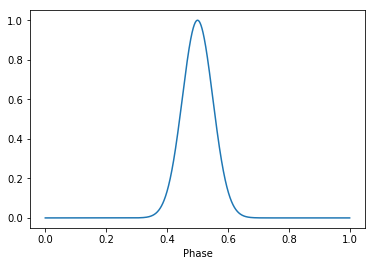

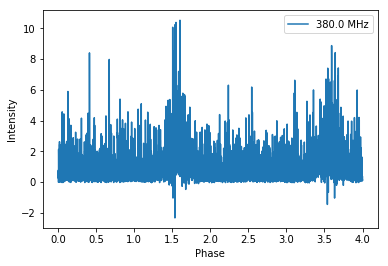

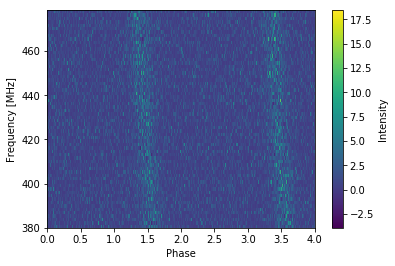

In [8]:
# We can look at the simulated profiles
plt.plot(np.linspace(0,1,2048), sim.profiles.profiles[0])
plt.xlabel("Phase")
plt.show()
plt.close()

# Get the simulated data
sim_data = sim.signal.data

# Get the phases of the pulse
phases = np.linspace(0, sim.tobs/sim.period, len(sim_data[0,:]))
# Plot just the pulses in the first frequency channels
plt.plot(phases, sim_data[0,:], label = sim.signal.dat_freq[0])
plt.ylabel("Intensity")
plt.xlabel("Phase")
plt.legend(loc = 'best')
plt.show()
plt.close()

# Make the 2-D plot of intensity v. frequency and pulse phase. You can see the slight dispersive sweep here.
plt.imshow(sim_data, aspect = 'auto', interpolation='nearest', origin = 'lower', \
           extent = [min(phases), max(phases), sim.signal.dat_freq[0].value, sim.signal.dat_freq[-1].value])
plt.ylabel("Frequency [MHz]")
plt.xlabel("Phase")
plt.colorbar(label = "Intensity")
plt.show()
plt.close()